# Notebook 1: Data Merging and Preprocessing
This notebook:
- Merges three datasets (political violence, demographics, and GDP).
- Renames columns and translates certain categorical variables.
- Performs initial data exploration and handling (dropping columns, dealing with missing values).
- Prepares a final CSV for modeling.


## 1. Information Merge
First we join three information sources as we believe this could give us better insights. Additionally to the base database we added two additional data sets from Mexico's statistical authority INEGI describing demographic and economic data from each state.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

# PLEASE UPDATE THE PATHS BELOW AS NEEDED
Political_violence = pd.read_csv(r"D:\05.Laboral\08.Git and github\06.Political violence\Data\Political_violence.csv")
Demographic_2020   = pd.read_csv(r"D:\05.Laboral\08.Git and github\06.Political violence\Data\population_data_by_state.csv")
Gdp                = pd.read_csv(r"D:\05.Laboral\08.Git and github\06.Political violence\Data\PIB.csv")

## 2. Group and Merge Demographic Data

We aggregate certain demographic columns by sum (e.g., population counts) and others by mean (e.g., average scholarity). Then we merge with political violence data and GDP data.

In [2]:
# Non aggregated columns for demographics
columns_to_keep_demographic_agg_sum = ["POBTOT","POBFEM","POBMAS","PEA","PSINDER","P12YM_SOLT","ID"]
columns_to_keep_demographic_agg_avg = ["GRAPROES","VIVTOT","PROM_OCUP","ID"]

# Create the aggregation dictionary
agg_dict = {col: 'sum'  for col in columns_to_keep_demographic_agg_sum}
agg_dict.update({col: 'mean' for col in columns_to_keep_demographic_agg_avg})

# Group the demographic data by 'ENTIDAD' (state) and aggregate
columns_to_keep_demographic = Demographic_2020.groupby('ENTIDAD').agg(agg_dict).reset_index()

# Explanation:
# - POBTOT: Total population
# - POBFEM: Female population
# - POBMAS: Male population
# - GRAPROES: Average scholarity
# - PEA: Economically active population
# - PSINDER: No health services population
# - P12YM_SOLT: 12-year-old single population
# - VIVTOT: Home count
# - PROM_OCUP: Average number of people in homes

# Economic data available until 2019
columns_to_keep_GDP = ["2019","Concepto"]

# Merge step 1: merge Political_violence with aggregated demographic data
database_first_merge = pd.merge(
    Political_violence, 
    columns_to_keep_demographic, 
    how='left', 
    left_on='cve_edoINEGI',
    right_on='ENTIDAD'
)

# Merge step 2: merge with the GDP data
database = pd.merge(
    database_first_merge,
    Gdp[columns_to_keep_GDP],
    how='left',
    left_on='estado',
    right_on='Concepto'
)

## 3. Rename Columns and Generate Final CSV
We rename columns to more descriptive English names, optionally translate some categories, and then export to a CSV for future modeling.

In [4]:
# Renaming columns
database = database.rename(columns={
    'Unnamed: 0': 'Number',
    'id': 'ID',
    'id_evento': 'event_id',
    'id_victima': 'victim_id',
    'tipo_vic': 'victim_type',
    'nom_vic': 'victim_name',
    'genero_vic': 'victim_gender',
    'partido1': 'party1',
    'partido2': 'party2',
    'partido3': 'party3',
    'partido4': 'party4',
    'coalicion': 'coallition',
    'puesto1': '1stpoliticaloffice',
    'puesto2': '2ndpoliticaloffice',
    'puesto3': '3rdpoliticaloffice',
    'cat_puesto1': 'general_category_1',
    'cat_puesto2': 'general_category_2',
    'cat_puesto3': 'general_category_3',
    'nivel_gob': 'level_of_government',
    'area_gob': 'government_area',
    'tipo_evento': 'event_type',
    'agresor': 'aggressor',
    'Obs_agresor': 'remarks_on_the_crime',
    'fecha': 'date',
    'estado': 'state',
    'municipio': 'municipal',
    'cve_edoINEGI': 'INEGIcode',
    'cve_munINEGI': 'MunINEGIcode',
    'ENTIDAD': 'Entity',
    'POBTOT': 'Totalpopulation',
    'POBFEM': 'Female_population',
    'POBMAS': 'Male_population',
    'GRAPROES': 'avg_scholarity',
    'PEA': 'economically_active_population',
    'PSINDER': 'No_health_services_pop',
    'P12YM_SOLT': '12_year_old_single_population',
    'VIVTOT': 'home_count',
    'PROM_OCUP': 'average_number_in_home',
    'ID': 'ID.1',
    '2019': 'GDP',
    'Concepto': 'Concepto'
})

# Optional translation of categories
translation_dict_victim = {
    'Autoridad': 'Authority',
    'Partido': 'Party',
    'Instalación': 'Facility'
}
database['victim_type'] = database['victim_type'].replace(translation_dict_victim)

translation_dict_gender = {
    'Hombre': 'Male',
    'Mujer': 'Female',
    'No aplica': 'Does not apply',
    'No disponible': 'Not Available'
}
database['victim_gender'] = database['victim_gender'].replace(translation_dict_gender)

translation_dict_level_of_government = {
    'Federal': 'Federal',
    'Municipal': 'Municipal',
    'Estatal': 'State'
}
database['level_of_government'] = database['level_of_government'].replace(translation_dict_level_of_government)

translation_dict_government_area = {
    'Economía y finanzas (e.g. tesorerías; catastros)': 'Economy and Finance',
    'Elecciones y campañas (e.g. candidatos; asesores y voluntarios de campaña)': 'Elections and Campaigns',
    'Ejecutivo (e.g. alcaldes y gobernadores junto con gabinetes)': 'Executive',
    'Judicial': 'Judicial',
    'Legislativo': 'Legislative',
    'Seguridad (e.g. policÃ­as; fuerzas del orden)': 'Security'
}
database['government_area'] = database['government_area'].replace(translation_dict_government_area)

translation_dict_event_type = {
    'Ataque armado': 'Armed Attack',
    'Atentado': 'Assault',
    'Desaparición': 'Dissappearance',
    'Secuestro': 'Kidnapping',
    'Asesinato': 'Murder',
    'Amenaza': 'Threat'
}
database['event_type'] = database['event_type'].replace(translation_dict_event_type)

# Save the final merged dataset
database.to_csv(r"D:\05.Laboral\08.Git and github\06.Political violence\Data\database.csv", index=False)

# Check for duplicates after merge
number_of_rows = database.shape[0]
print("Final number of rows in merged dataset:", number_of_rows)

Final number of rows in merged dataset: 2109


## 4. Data Preprocessing
- Drop columns not needed.
- Handle missing values.
- Basic exploration.

Below is an example approach. Adapt as you see fit.

In [6]:
# Load the processed data
pdv = pd.read_csv(r"D:\05.Laboral\08.Git and github\06.Political violence\Data\database.csv") # Update path as needed

# Display all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

pdv.info()
pdv.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109 entries, 0 to 2108
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Number                          2109 non-null   int64  
 1   ID.1                            2109 non-null   object 
 2   event_id                        2109 non-null   int64  
 3   victim_id                       2109 non-null   int64  
 4   victim_type                     2109 non-null   object 
 5   victim_name                     2109 non-null   object 
 6   victim_gender                   2109 non-null   object 
 7   party1                          2067 non-null   object 
 8   party2                          123 non-null    object 
 9   party3                          83 non-null     object 
 10  party4                          4 non-null      object 
 11  coallition                      164 non-null    object 
 12  1stpoliticaloffice              21

,Number,event_id,victim_id,INEGIcode,MunINEGIcode,Entity,Totalpopulation,Female_population,Male_population,economically_active_population,No_health_services_pop,12_year_old_single_population,ID.1.1,avg_scholarity,home_count,average_number_in_home,GDP
count,2109.000000,2109.000000,2109.000000,2109.000000,2109.000000,2109.000000,2.109000e+03,2.109000e+03,2.109000e+03,2.109000e+03,2.109000e+03,2.109000e+03,2109.000000,2109.000000,2109.000000,2109.000000,1.441000e+03
mean,1055.000000,891.431958,992.999526,16.890944,55.724514,16.890944,5.193460e+06,2.670605e+06,2.522853e+06,2.525438e+06,1.431772e+06,1.391520e+06,1775.378007,8.844357,657.217939,3.577538,4.309682e+05
std,608.960179,502.220958,572.421302,8.022706,75.142392,8.022706,3.351007e+06,1.728157e+06,1.623440e+06,1.690504e+06,1.141995e+06,9.567648e+05,1847.982257,1.001153,143.375424,0.246425,2.937642e+05
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,7.313910e+05,3.707690e+05,3.606220e+05,3.866420e+05,1.230740e+05,2.016010e+05,187.670270,7.396834,282.078884,3.156682,1.035648e+05
25%,528.000000,461.000000,501.000000,11.000000,10.000000,11.000000,3.082841e+06,1.601462e+06,1.494793e+06,1.502364e+06,7.138590e+05,8.250420e+05,1050.000000,8.089049,619.370812,3.352510,2.407498e+05
50%,1055.000000,900.000000,987.000000,16.000000,31.000000,16.000000,4.132148e+06,2.157305e+06,1.974843e+06,2.010892e+06,1.215990e+06,1.085230e+06,1366.408096,8.676868,635.433962,3.587277,2.616845e+05
75%,1582.000000,1315.000000,1487.000000,21.000000,67.000000,21.000000,6.166934e+06,3.170480e+06,2.996454e+06,2.997139e+06,1.814782e+06,1.678577e+06,1591.657703,9.782062,807.243926,3.786890,5.953933e+05
max,2109.000000,1767.000000,1988.000000,32.000000,568.000000,32.000000,1.699242e+07,8.741123e+06,8.251295e+06,8.544416e+06,5.672574e+06,4.799091e+06,9822.752445,11.668148,927.444444,4.093721,1.216736e+06


### Example Column Drops
We drop identifiers and columns with high missingness or no predictive power.

In [7]:
columns_to_drop = [
    "Number","ID","victim_name", "party2","party3","party4",
    "1stpoliticaloffice","2ndpoliticaloffice","3rdpoliticaloffice",
    "remarks_on_the_crime","INEGIcode","MunINEGIcode","ID.1",
    "Concepto","municipal"
]
pdv = pdv.drop(columns=columns_to_drop, axis=1, errors='ignore')

pdv.head(2)

,event_id,victim_id,victim_type,victim_gender,party1,coallition,general_category_1,general_category_2,general_category_3,level_of_government,government_area,event_type,aggressor,date,state,Entity,Totalpopulation,Female_population,Male_population,economically_active_population,No_health_services_pop,12_year_old_single_population,ID.1.1,avg_scholarity,home_count,average_number_in_home,GDP
0,1,1,Authority,Male,PRD,NaN,Alcalde(sa),NaN,NaN,Municipal,Executive,Murder,Sujeto(s) armado(s),2017-12-29,Guerrero,12,3540685,1840073,1700612,1635187,891961,870839,1415.581378,7.396834,490.228305,3.78689,240749.756
1,2,2,Party,Female,PRI,NaN,Pre-candidato(a),NaN,NaN,Municipal,Elections and Campaigns,Murder,No identificado,2018-01-01,Guerrero,12,3540685,1840073,1700612,1635187,891961,870839,1415.581378,7.396834,490.228305,3.78689,240749.756


### Visualizing Missing Values

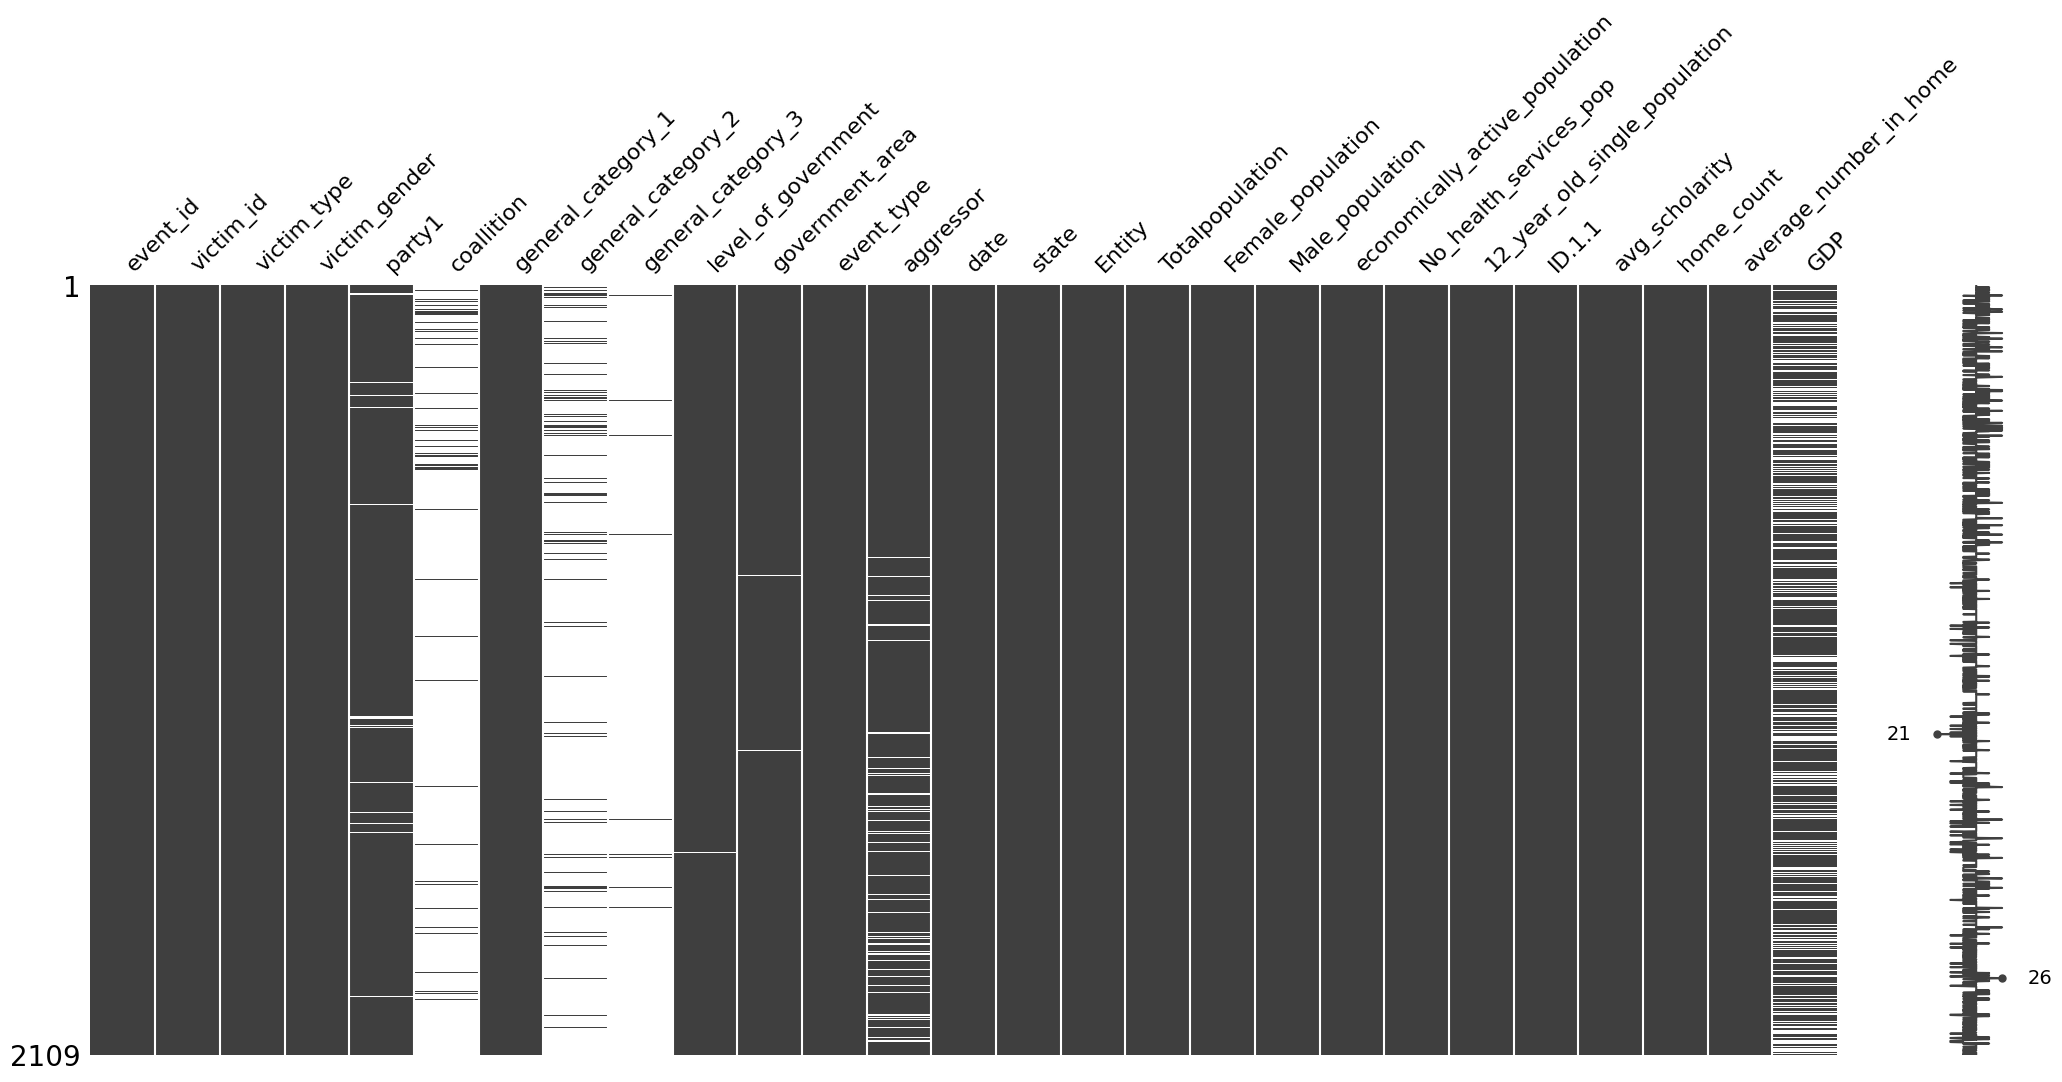

In [8]:
msno.matrix(pdv)
plt.show()

### Example Frequency Tables and Plots

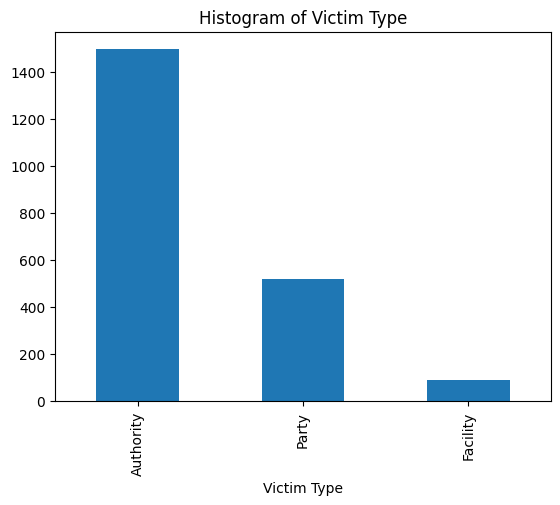

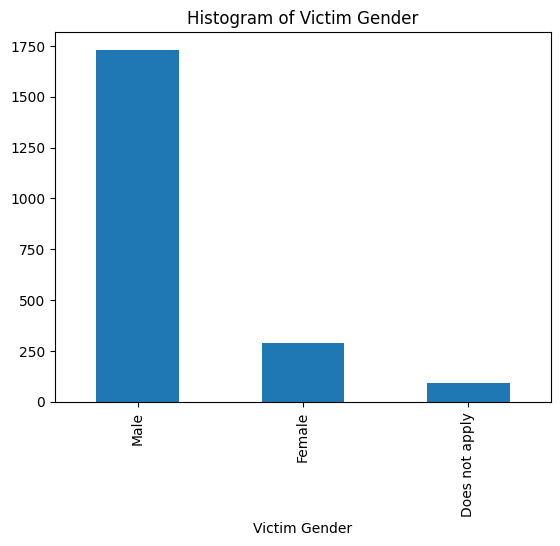

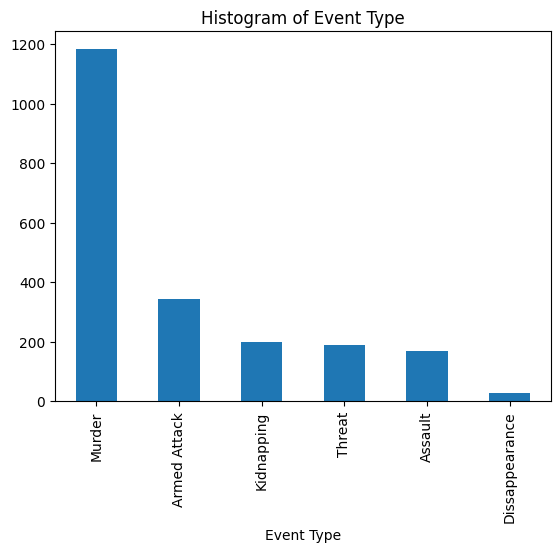

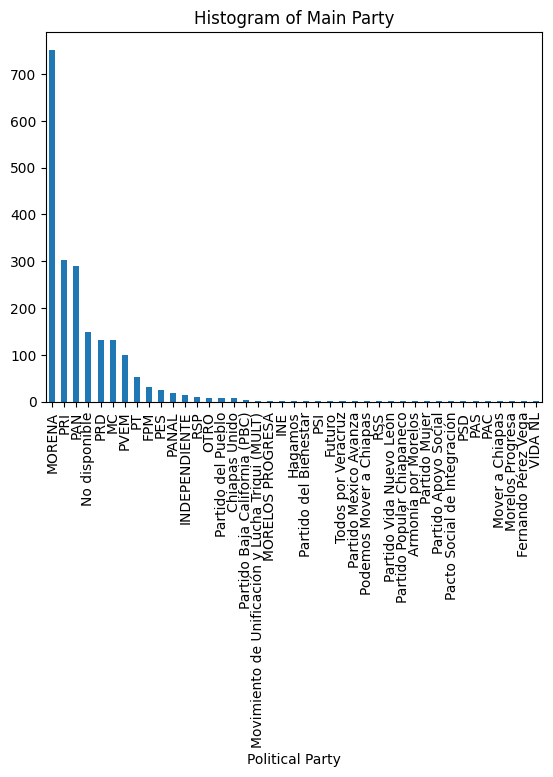

col_0                                            counts
party1                                                 
MORENA                                              752
PRI                                                 303
PAN                                                 291
No disponible                                       148
PRD                                                 132
MC                                                  131
PVEM                                                 99
PT                                                   53
FPM                                                  31
PES                                                  25
PANAL                                                19
INDEPENDIENTE                                        15
RSP                                                  10
OTRO                                                  9
Partido del Pueblo                                    7
Chiapas Unido                                   

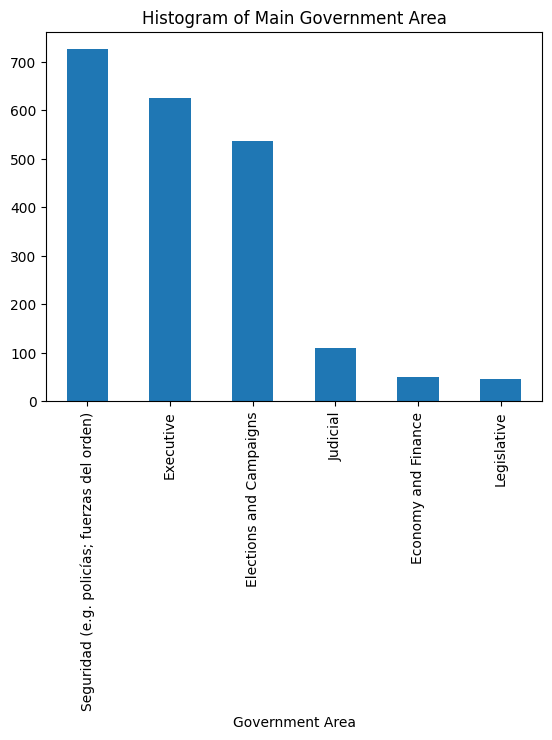

In [9]:
# Victim type frequency
frequency_victim = pd.crosstab(index=pdv['victim_type'], columns='counts').sort_values(by='counts', ascending=False)
frequency_victim.plot(kind='bar', legend=False)
plt.xlabel('Victim Type')
plt.title('Histogram of Victim Type')
plt.show()

# Victim gender frequency
# Example approach: if 'Not Available', impute with 'Male'
pdv.loc[pdv['victim_gender'] == 'Not Available', 'victim_gender'] = "Male"
frequency_victim_gender = pd.crosstab(index=pdv['victim_gender'], columns='counts').sort_values(by='counts', ascending=False)
frequency_victim_gender.plot(kind='bar', legend=False)
plt.xlabel('Victim Gender')
plt.title('Histogram of Victim Gender')
plt.show()

# Event type frequency
frequency_event = pd.crosstab(index=pdv['event_type'], columns='counts').sort_values(by='counts', ascending=False)
frequency_event.plot(kind='bar', legend=False)
plt.xlabel('Event Type')
plt.title('Histogram of Event Type')
plt.show()

# Party1 frequency
frequency_event_party = pd.crosstab(index=pdv['party1'], columns='counts').sort_values(by='counts', ascending=False)
frequency_event_party.plot(kind='bar', legend=False)
plt.xlabel('Political Party')
plt.title('Histogram of Main Party')
plt.show()
print(frequency_event_party)

# Government area frequency
frequency_government_area = pd.crosstab(index=pdv['government_area'], columns='counts').sort_values(by='counts', ascending=False)
frequency_government_area.plot(kind='bar', legend=False)
plt.xlabel('Government Area')
plt.title('Histogram of Main Government Area')
plt.show()

### Drop Columns with High Missingness or Redundancy
For instance, `coallition`, `general_category_2`, `general_category_3`.

In [10]:
columns_to_drop_missing = ['general_category_2', 'general_category_3','coallition']
pdv = pdv.drop(columns=columns_to_drop_missing, errors='ignore')
pdv.head(2)

,event_id,victim_id,victim_type,victim_gender,party1,general_category_1,level_of_government,government_area,event_type,aggressor,date,state,Entity,Totalpopulation,Female_population,Male_population,economically_active_population,No_health_services_pop,12_year_old_single_population,ID.1.1,avg_scholarity,home_count,average_number_in_home,GDP
0,1,1,Authority,Male,PRD,Alcalde(sa),Municipal,Executive,Murder,Sujeto(s) armado(s),2017-12-29,Guerrero,12,3540685,1840073,1700612,1635187,891961,870839,1415.581378,7.396834,490.228305,3.78689,240749.756
1,2,2,Party,Female,PRI,Pre-candidato(a),Municipal,Elections and Campaigns,Murder,No identificado,2018-01-01,Guerrero,12,3540685,1840073,1700612,1635187,891961,870839,1415.581378,7.396834,490.228305,3.78689,240749.756


### Handling Missing GDP
Fill with median or a state-specific approach.

In [11]:
gdp_median = pdv['GDP'].median()
pdv['GDP'] = pdv['GDP'].fillna(gdp_median)

gdp_by_state = pdv.groupby('state')['GDP'].unique()
print(gdp_by_state)

state
Aguascalientes                      [222451.271]
Baja_California                     [261684.516]
Campeche                            [517309.327]
Chiapas                             [261684.516]
Chihuahua                           [572880.305]
Ciudad_de_Mexico                    [261684.516]
Coahuila_de_Zaragoza                [261684.516]
Colima                              [109098.972]
Durango                             [204045.941]
Guanajuato                          [701795.455]
Guerrero                            [240749.756]
Hidalgo                             [272452.995]
Jalisco                            [1216735.696]
Mexico                              [261684.516]
Michoacan_de_Ocampo                 [261684.516]
Morelos                             [201049.316]
Nayarit                             [121042.682]
Nuevo_Leon                          [261684.516]
Oaxaca                              [252892.486]
Puebla                              [595393.262]
Queretaro     

### Drop Rows with Missing Government-Area Data

In [12]:
columns_to_drop_rows = ['level_of_government', 'government_area']
for col in columns_to_drop_rows:
    pdv.dropna(subset=[col], inplace=True)

### Correlation Heatmap
Check for collinearity.

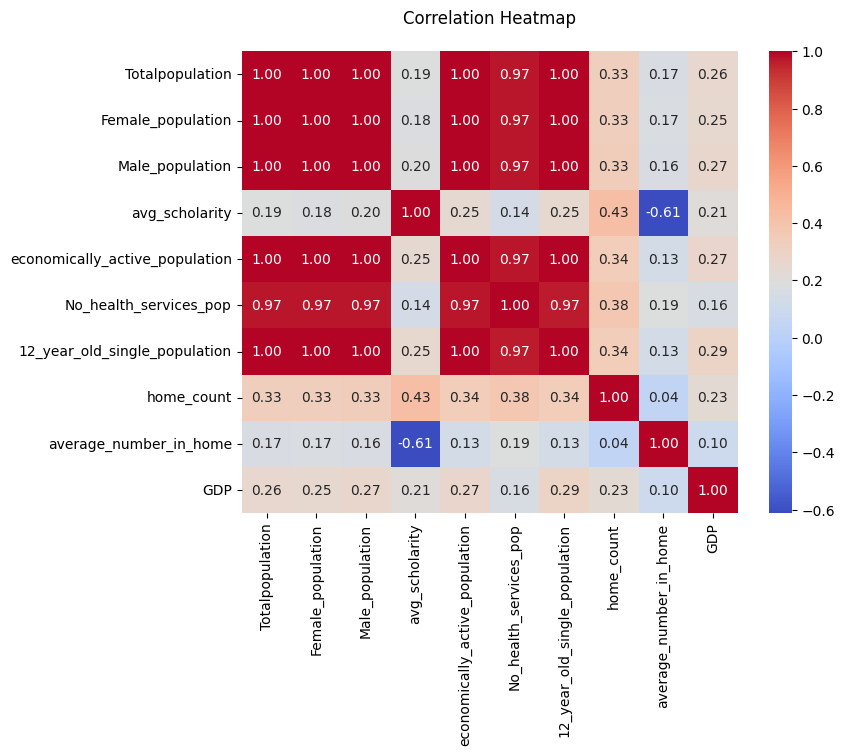

In [13]:
numerical_columns = [
    'Totalpopulation', 'Female_population', 'Male_population', 'avg_scholarity',
    'economically_active_population', 'No_health_services_pop', 
    '12_year_old_single_population', 'home_count', 'average_number_in_home', 'GDP'
]
correlation_matrix = pdv[numerical_columns].corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap', pad=20)
plt.show()

### Possible Collinearity Handling
If `economically_active_population` is strongly correlated with `GDP`, we can drop it.

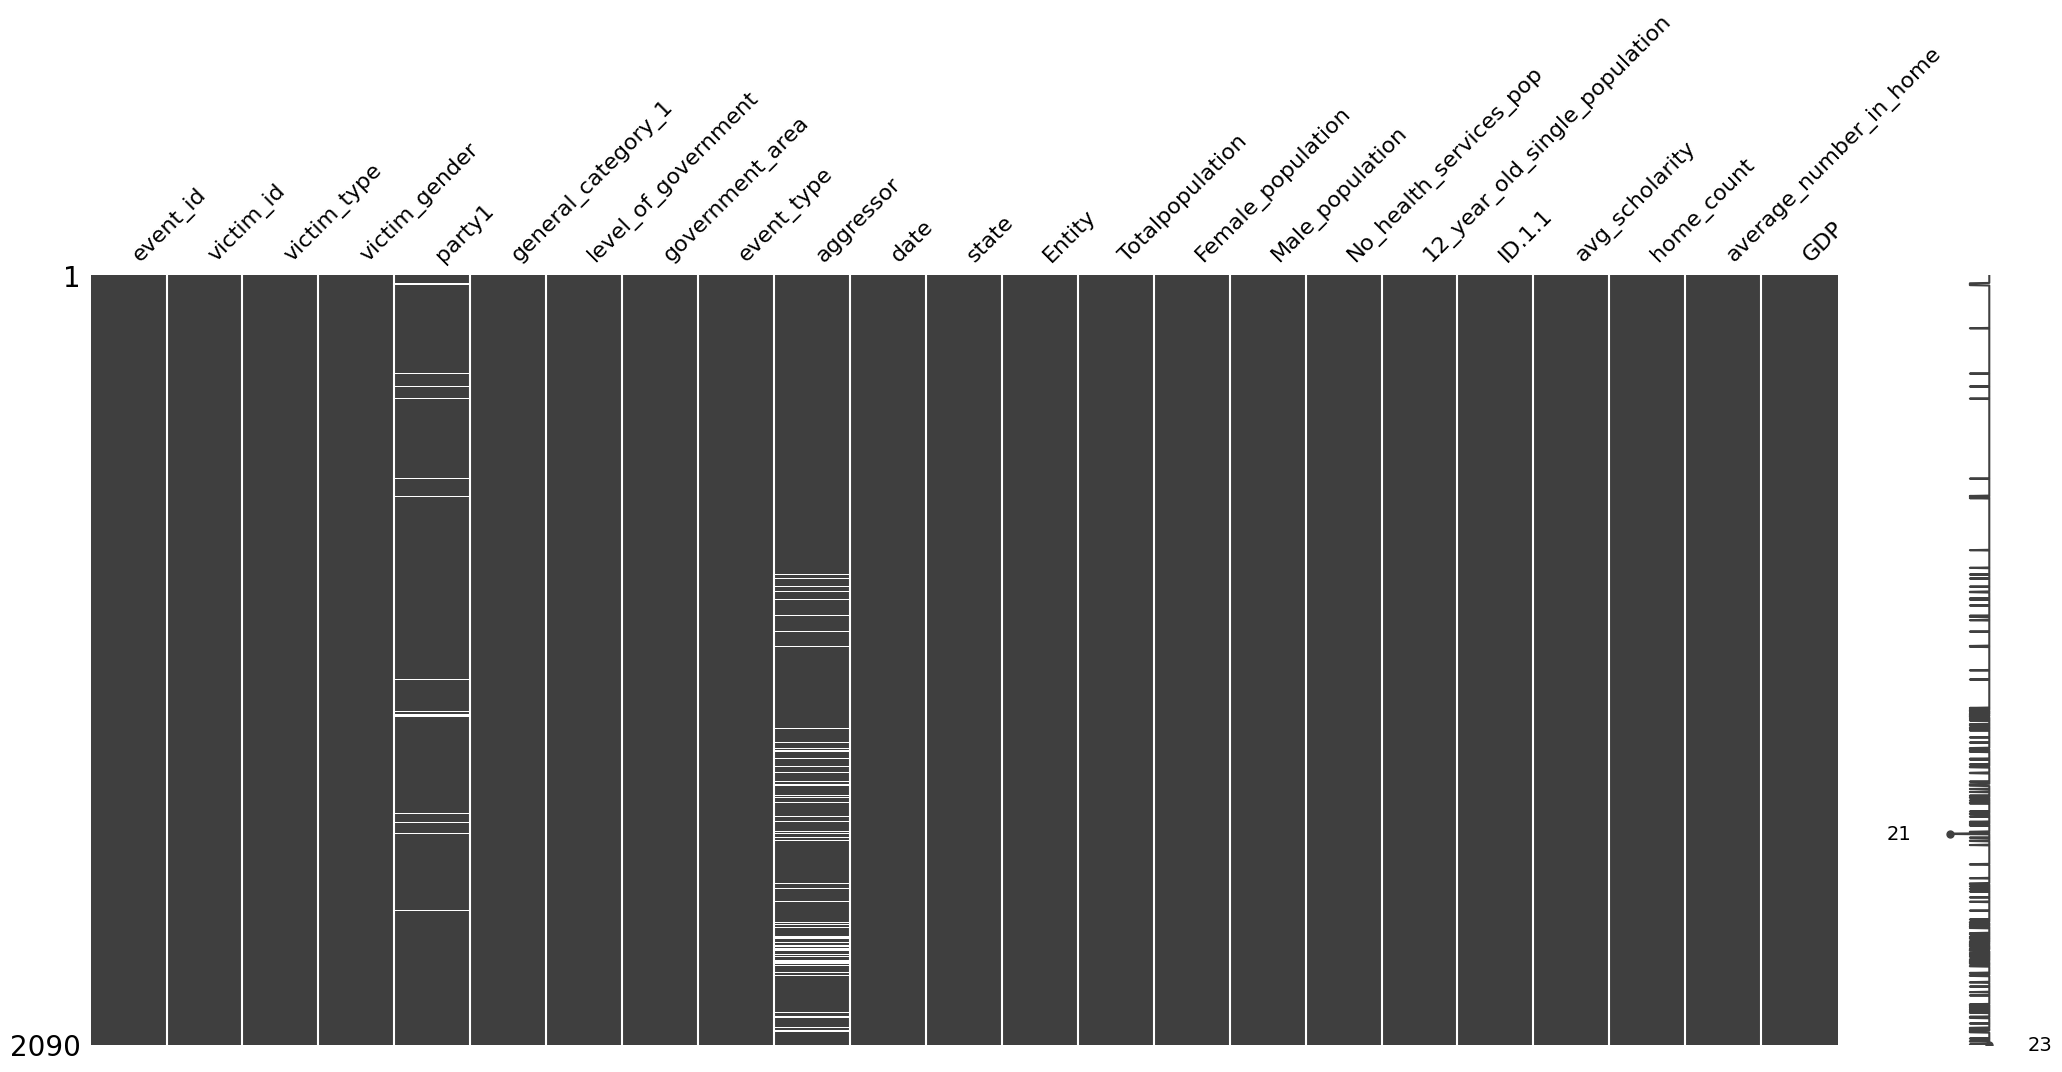

In [14]:
pdv = pdv.drop(columns='economically_active_population', axis=1, errors='ignore')
msno.matrix(pdv)
plt.show()

## End of Notebook 1
At this point, `pdv` is your cleaned and preprocessed dataset. You can export it to CSV for modeling:
```
pdv.to_csv("PATH/preprocessed_data.csv", index=False)
```
Then proceed to **Notebook 2** for modeling.

In [15]:
pdv.to_csv("D:/05.Laboral/08.Git and github/06.Political violence/Data/preprocessed_data.csv", index=False)